In [ ]:
# Este ambiente Python 3 vem com muitas bibliotecas de análise úteis instaladas
# Ele é definido pela imagem Docker kaggle/python: https://github.com/kaggle/docker-python
# Por exemplo, aqui estão vários pacotes úteis para carregar

import numpy as np # álgebra linear
import pandas as pd # processamento de dados, E/S de arquivos CSV (por exemplo, pd.read_csv)

# Os arquivos de dados de entrada estão disponíveis no diretório somente leitura "../input/"
# Por exemplo, executar isso (clicando em executar ou pressionando Shift+Enter) listará todos os arquivos no diretório de entrada

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Você pode escrever até 20GB no diretório atual (/kaggle/working/) que é preservado como saída quando você cria uma versão usando "Salvar & Executar Tudo"
# Você também pode escrever arquivos temporários em /kaggle/temp/, mas eles não serão salvos fora da sessão atual

## Introdução

Neste notebook, demonstraremos como usar o minisom para fazer clustering de topologia linear

Por favor, vote positivamente neste notebook se achar útil :)

Jonathan Kristanto &copy; Maio 2021

## Bibliotecas

Créditos a Giuseppe Vettigli (Just Glowing) pela biblioteca MiniSom que eu uso aqui para implementar o Self Organizing Map (SOM)

Repositório: https://github.com/JustGlowing/minisom

In [2]:
from minisom import MiniSom  

import matplotlib.pyplot as plt
%matplotlib inline

## Importar Dados

In [ ]:
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## Seleção de Características

Veremos quais combinações de características podem ser agrupadas

In [4]:
plt.style.use('fivethirtyeight')

### Distribuição de Dados de Idade e Pontuação de Gastos

Resultado: Nenhum cluster aparente detectado

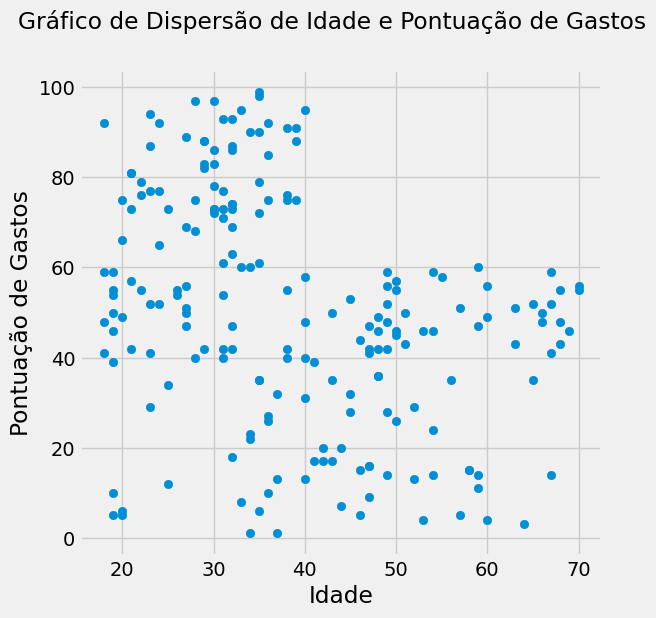

In [5]:
age = df['Age'].tolist()
spending_score = df['Spending Score (1-100)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(age, spending_score)
plt.suptitle("Gráfico de Dispersão de Idade e Pontuação de Gastos")
plt.xlabel("Idade")
plt.ylabel("Pontuação de Gastos")
plt.show()

### Distribuição de Dados de Idade e Renda Anual

Resultado: Nenhum cluster aparente detectado

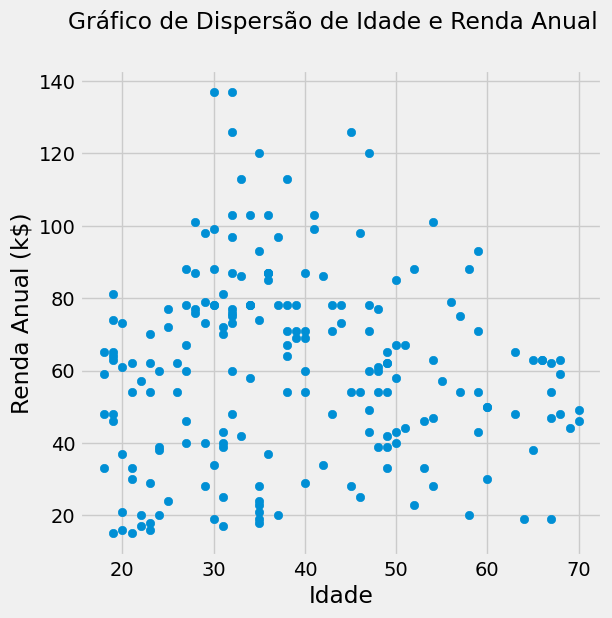

In [6]:
age = df['Age'].tolist()
annual_income = df['Annual Income (k$)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(age, annual_income)
plt.suptitle("Gráfico de Dispersão de Idade e Renda Anual")
plt.xlabel("Idade")
plt.ylabel("Renda Anual (k$)")
plt.show()

### Distribuição de Dados de Renda Anual e Pontuação de Gastos

**Resultado: Existem 5 clusters detectados**

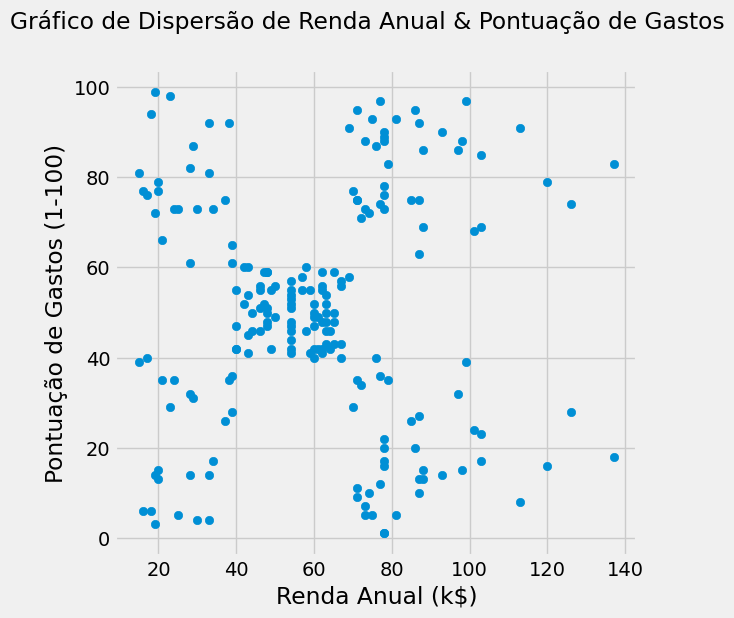

In [7]:
annual_income = df['Annual Income (k$)'].tolist()
spending_score = df['Spending Score (1-100)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(annual_income, spending_score)
plt.suptitle("Gráfico de Dispersão de Renda Anual & Pontuação de Gastos")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.show()

## Limpar & Transformar Dados

In [8]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [9]:
# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Transformar características em lista
data = features.values
data.shape

(200, 2)

# TREINAMENTOS 


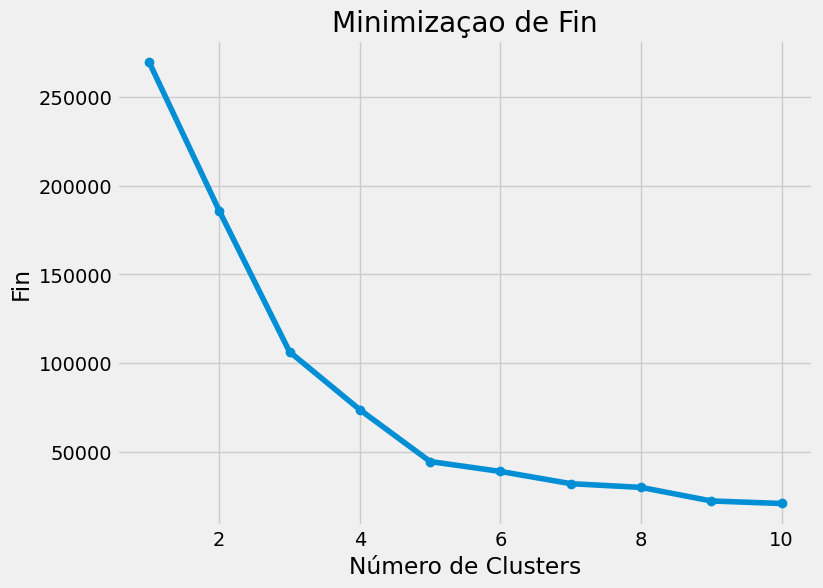

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Definir o intervalo de possíveis números de clusters
range_n_clusters = range(1, 11)

# Lista para armazenar a inércia para cada número de clusters
inertia = []

# Calcular a inércia para cada número de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Minimizaçao de Fin')
plt.xlabel('Número de Clusters')
plt.ylabel('Fin')
plt.show()

## Treinar SOM

In [11]:
# Eu uso topografia linear som
som_shape = (1, 5)

som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=0.5, learning_rate=0.5)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

# plt.plot(np.arange(max_iter), q_error, label='erro de quantização')
# plt.plot(np.arange(max_iter), t_error, label='erro topográfico')
# plt.ylabel('Erro de quantização')
# plt.xlabel('Índice de iteração')
# plt.legend()
# plt.show()

### Gráfico de Resultados

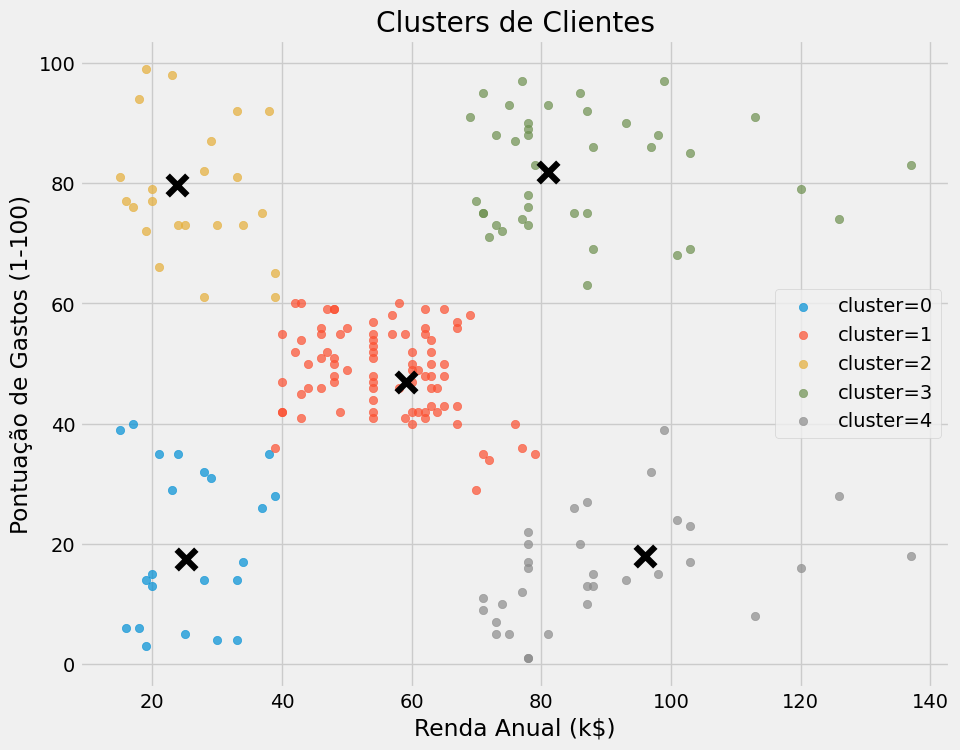

In [12]:
# cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(10,8))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotando centróides
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=10, linewidths=20, color='k') # label='centróide'
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();

## K-MEANS
 

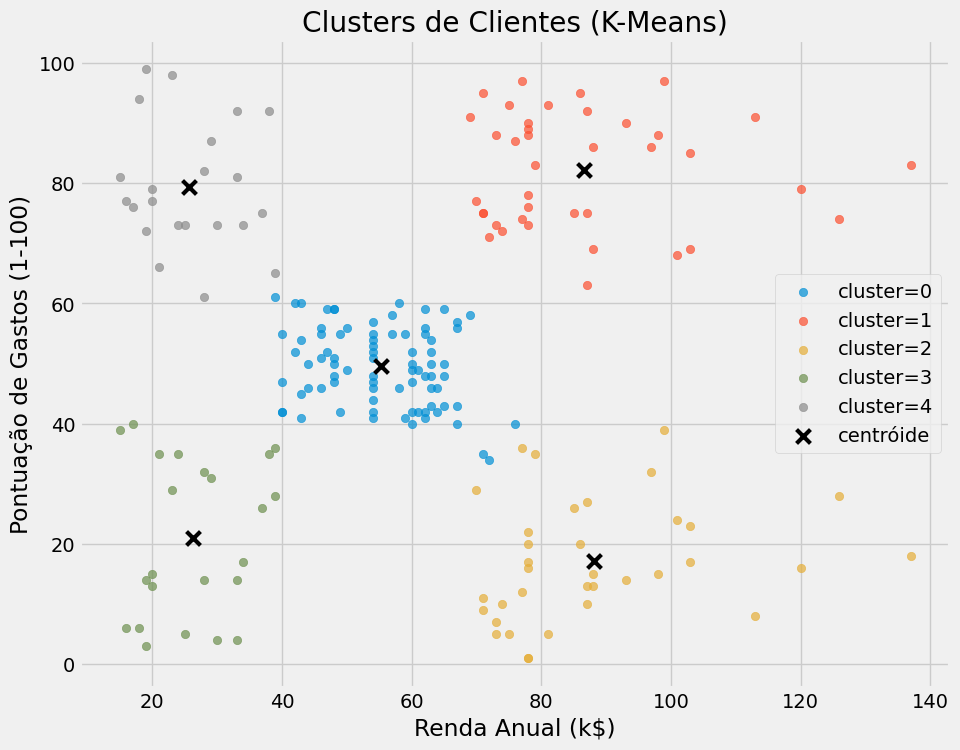

In [13]:
from sklearn.cluster import KMeans

# Definir o número de clusters
n_clusters = 5

# Inicializar o modelo K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Treinar o modelo
kmeans.fit(data)

# Obter os rótulos dos clusters
labels = kmeans.labels_

# Plotar os clusters
plt.figure(figsize=(10,8))

for c in np.unique(labels):
    plt.scatter(data[labels == c, 0],
                data[labels == c, 1], label='cluster='+str(c), alpha=.7)

# Plotar centróides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', 
            s=100, linewidths=3, color='k', label='centróide')

plt.title("Clusters de Clientes (K-Means)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

## Kohonen

In [ ]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom

# Carregar o dataset
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Normalizar os dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Configurar e treinar o SOM
som_shape = (1, 5)  # Definindo a topologia linear com 5 neurônios
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=0.5, learning_rate=0.5)
som.random_weights_init(data)
som.train_random(data, 1000)  # Treinar o SOM com 1000 iterações

# Obter os clusters
winner_coordinates = np.array([som.winner(x) for x in data]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotar os clusters
plt.figure(figsize=(10, 8))
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0], data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotar centróides
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=100, linewidths=3, color='k', label='centróide')

plt.title("Clusters de Clientes (SOM)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

## ART

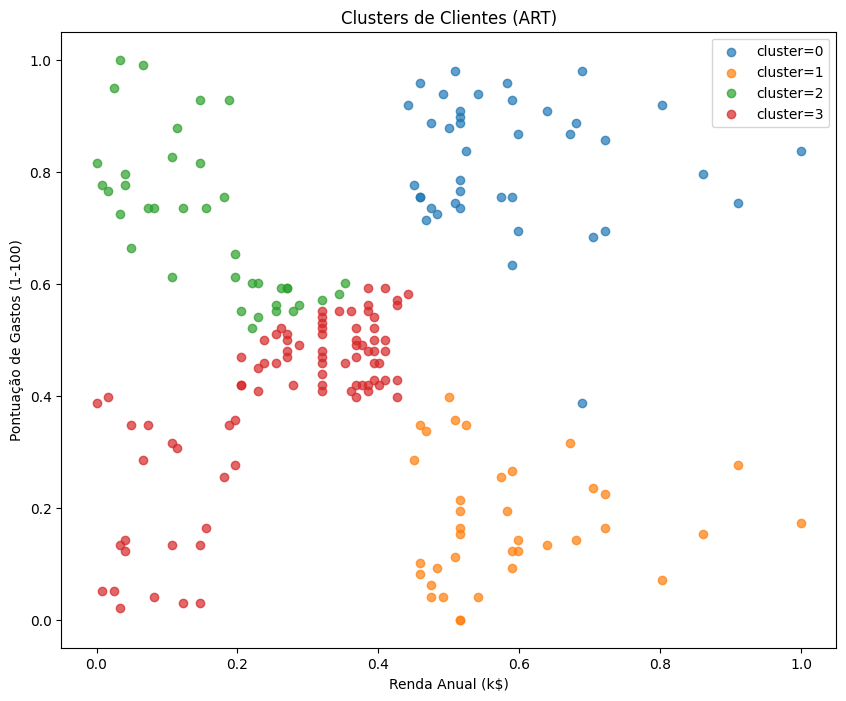

In [2]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Normalizar os dados
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Implementar ART
class ART:
    def __init__(self, vigilance=0.5):
        self.vigilance = vigilance
        self.weights = []

    def train(self, data):
        for sample in data:
            if not self.weights:
                self.weights.append(sample)
            else:
                for i, weight in enumerate(self.weights):
                    if np.linalg.norm(sample - weight) <= self.vigilance:
                        self.weights[i] = (self.weights[i] + sample) / 2
                        break
                else:
                    self.weights.append(sample)

    def predict(self, data):
        labels = []
        for sample in data:
            for i, weight in enumerate(self.weights):
                if np.linalg.norm(sample - weight) <= self.vigilance:
                    labels.append(i)
                    break
            else:
                labels.append(len(self.weights))
        return labels

# Configurar e treinar o ART
art = ART(vigilance=0.5)
art.train(data)

# Obter os clusters
labels = art.predict(data)

# Plotar os clusters
plt.figure(figsize=(10, 8))
for c in np.unique(labels):
    plt.scatter(data[labels == c, 0], data[labels == c, 1], label='cluster='+str(c), alpha=.7)

plt.title("Clusters de Clientes (ART)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

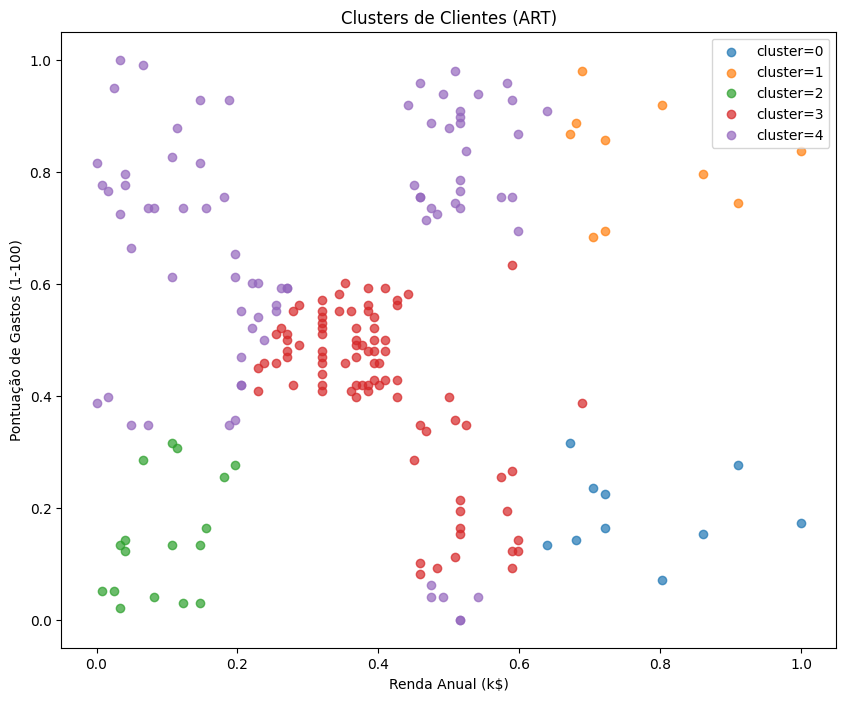

In [3]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Normalizar os dados
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Implementar ART
class ART:
    def __init__(self, vigilance=0.5):
        self.vigilance = vigilance
        self.weights = []

    def train(self, data):
        for sample in data:
            if not self.weights:
                self.weights.append(sample)
            else:
                for i, weight in enumerate(self.weights):
                    if np.linalg.norm(sample - weight) <= self.vigilance:
                        self.weights[i] = (self.weights[i] + sample) / 2
                        break
                else:
                    self.weights.append(sample)

    def predict(self, data):
        labels = []
        for sample in data:
            for i, weight in enumerate(self.weights):
                if np.linalg.norm(sample - weight) <= self.vigilance:
                    labels.append(i)
                    break
            else:
                labels.append(len(self.weights))
        return labels

# Configurar e treinar o ART
art = ART(vigilance=0.3)  # Ajuste o valor de vigilância para obter 5 classes
art.train(data)

# Obter os clusters
labels = art.predict(data)

# Plotar os clusters
plt.figure(figsize=(10, 8))
for c in np.unique(labels):
    plt.scatter(data[labels == c, 0], data[labels == c, 1], label='cluster='+str(c), alpha=.7)

plt.title("Clusters de Clientes (ART)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

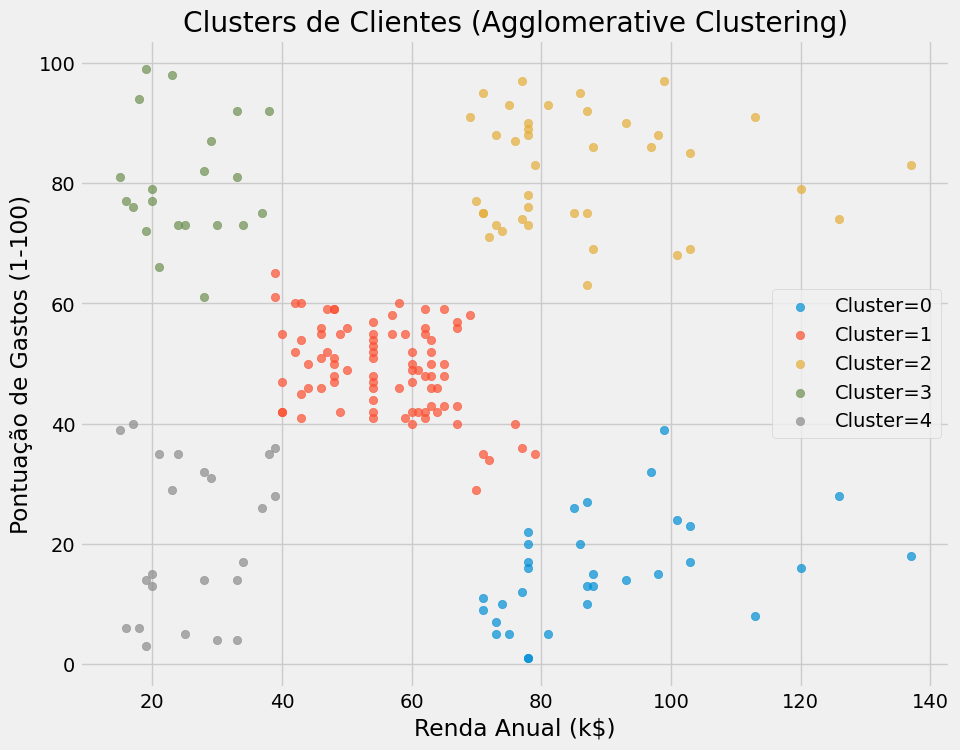

In [15]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd

# Carregar os dados
DATA_DIR = './Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Definir o número de clusters
n_clusters = 5

# Inicializar o modelo AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Treinar o modelo
labels = agg_clustering.fit_predict(data)

# Plotar os clusters
plt.figure(figsize=(10, 8))

for c in np.unique(labels):
    plt.scatter(data[labels == c, 0],
                data[labels == c, 1], label='Cluster='+str(c), alpha=.7)

plt.title("Clusters de Clientes (Agglomerative Clustering)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

## Resultado Final
Aqui podemos ver que existem 5 clusters de clientes com base na renda anual e na pontuação de gastos:

Cluster 0: Alta renda, baixo gasto

Cluster 1: Alta renda, alto gasto

Cluster 2: Baixa renda, alto gasto

Cluster 3: Renda média, gasto médio

Cluster 4: Baixa renda, baixo gasto